Prima di tutto abilitiamo l'estensione autoreaload di Jupyter

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sistemi Dinamici Tempo Discreti

## Volpi e Conigli

**Consideriamo l'evoluzione di una popolazione di volpi e conigli**

Useremo un modello semplificato definito dalla seguente ricorsione:

$$\begin{align}
v_{k+1} &= v_k + r_v (c_k - p v_k) \\
c_{k+1} &= r_c c_k - p v_k
\end{align}$$

Dove:

* $v_k$ è il numero di volpi al tempo $k$
* $c_k$ è il numero di conigli al tempo $k$
* $r_c$ è il tasso di riproduzione dei conigli
* $p$ è il tasso di predazione delle volpi sui conigli
* $r_v$ è l'impatto della abbondanza/scarsità di conigli sulle volpi

## ...E Sistemi Dinamici Discreti

**Si tratta di un esempio di _sistema dinamico discreto_**

...Che in generale è descritto da una ricorsione del tipo:

$$
x_{k+1} = f(x_k, k)
$$

**Il sistema ha uno _stato_**

* Nel caso generale $x_k$ è un vettore ed ha molte componenti
* ...Ma in casi più semplici può essere uno scalare

**Lo stato _varia_ in modo discreto nel tempo (i.e. $k$)**

* La funzione $f$ si chiama _funzione di transizione_
* ...Ed in generale può dipendere dallo stato corrente (i.e. $x_k$)
* ...Ma anche dal tempo

## Volpi e Conigli Come Sistema Dinamico Discreto

**Nel nostro caso abbiamo:**

$$
x_{k+1} = 
\left(\begin{array}{c}
v_{k+1} \\
c_{k+1}
\end{array}\right)
=
\left(\begin{array}{c}
v_k + r_v (c_k - p v_k) \\
r_c c_k - p v_k
\end{array}\right)
= f(x_k, k)
$$

* Lo stato $x_k$ ha due componenti, i.e. numero di volpi e congli
* La funzione di transizione è vettoriale
* La funzione di transizione non ha una vera dipendenza diretta dal tempo
* ...Perché $k$ non compare come termine nella sua formula

## Evoluzione di Sistemi Dinamici Discreti

**Si può simulare l'evoluzione di un sistema di questo tipo**

...Usando algoritmo semplice e generale

* Dato uno stato iniziale $x_0$ ed un numero di passi $n$
* Memorizza lo stato $x_0$, associato al passo 0
* Ripeti per $k$ che va da $0$ ad $n-1$:
  - Calcola $x_{k+1}$ usando $f(x_k, k)$
  - Memorizza il nuovo stato, associato al passo $k+1$

## Evoluzione di Sistemi Dinamici Discreti

**Possiamo codificare l'algoritmo come segue:**

```python
def simulate(f, X0, n):
    res = [X0] # Lo stato al passo 0 è x0
    for k in range(0, n):
        xnext = f(res[k], k) # Ottengo il prossimo stato
        res.append(xnext) # Aggiungo il nuovo stato in fondo alla lista
    return np.array(res) # Converto in numpy array e restituisco
```

* La funzione `f` è chiamata con due parametri
* ...Ossia lo stato (in `res[k]`) ed il tempo `k`
* Durate il calcolo gli stati sono memorizzati in una lista
* Al momento della restituzione, la lista è convertita in un `array`

**L'algoritmo è disponibile nel modulo `base.sim`**

## Esempio: Volpi e Conigli

**Per poter eseguire l'algoritmo dobbiamo definire la funzione di transizione**

Potremmo pensare di impostarla così:

```python
def volpi_conigli(X, k, rv=1.05, rc=2, p=2.5):
    v, c = X # "Spacchetto" lo stato
    nv = v + rv * (c - p * v) # volpi al prossimo passo
    nc = rc*c - p * v # conigli al prossimo passo
    return np.array([nv, nc])
```

In [4]:
from esempio import vc # la funzione è definita in questo modulo
print(vc.volpi_conigli(X=(4, 100), k=0))
print(vc.volpi_conigli(X=(4, 100), k=0, p=2))

[ 98.5 190. ]
[100.6 192. ]


* Possiamo invocarl passando solo `X` e `k`, ma anche specificare gli altri parametri

## Esempio: Volpi e Conigli

**La nostra funzione può essere usata all'interno di `simulate`**

In [5]:
from base import sim
X0 = [4, 100]
X = sim.simulate(vc.volpi_conigli, X0, n=100)
print(X[:4]) # Primi 4 stati visitati

[[  4.        100.       ]
 [ 98.5       190.       ]
 [ 39.4375    133.75     ]
 [ 76.3515625 168.90625  ]]


* `simulate` invoca `volpi_conigli` passando i valori di `X` e `k`

Il risultato è una matrice (array bi-dimensionale):

* Ogni riga è associata ad un valore di tempo
* Ogni colonna è associata ad una componente dello stato

## Esempio: Volpi e Conigli

**Possiamo disegnare gli andamenti delle due componenti di stato**

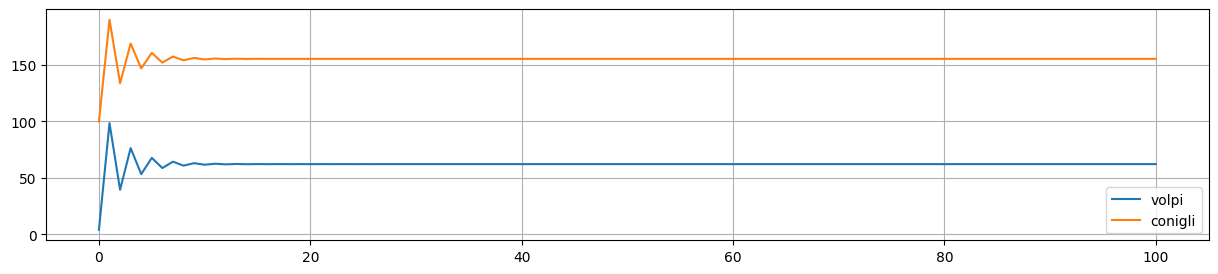

In [6]:
X0 = [4, 100]
X = sim.simulate(vc.volpi_conigli, X0, n=100)
sim.plot_sim(X, names=['volpi', 'conigli'])

* La funzione `plot_sim` è definita nel modulo `base.sim`
* Potete dare un'occhiata al codice, per vedere nei dettagli come funziona

## Un Problema e Due Soluzioni Imperfette

**L'approccio che abbiamo usato funziona**

...Ma non permette di fare esperimenti con diversi valori di $r_v$, $r_c$ e $p$

* Possiamo cambiare $r_v$, $r_c$ e $p$ al momento della chiamata di `volpi_conigli`
* Ma durante un esperimento, la chiamata viene effettuata da `simulate`
* ...Che passa solo i valori di `X` e `k`

**Due possibili soluzioni (entrambe inadeguate):**

* Possiamo cambiare i valori di default di `rv`, `rc` e `p`
  - ...Ma così facendo dobbiamo cambiare il codice prima di ogni esperimento
* Possiamo fare in modo che `simulate` specifichi anche `rv`, `rc` e `p`
  - ...Ma così facendo l'algoritmo non è più generico

## Una Soluzione Basata su Classi Funzione

**Possiamo risolvere il problema usando una classe funzione (in `base.vc`)**

```python
class VolpiConigli:
    def __init__(self, rv, rc, p):
        self.p = p
        self.rv = rv
        self.rc = rc

    def __call__(self, X, k): # Funzione di transizione
        v, c = X
        nv = v + self.rv * (c - self.p * v)
        nc = self.rc*c - self.p * v
        return np.array([nv, nc])
```

* I valori di `rv`, `rc` e `p` sono passati _durante la costruzione_
* I valorid di `X` e `k` sono passati _durante l'invocazione_

## Una Soluzione Basata su Classi Funzione

**Ora possiamo costruire _più istanze_ della funzione di transizione**

...Ciascuna con i suoi valori per $r_v$, $r_c$ e $p$

In [7]:
f1 = vc.VolpiConigli(rv=1.05, rc=2, p=2.5)
f2 = vc.VolpiConigli(rv=1.05, rc=2, p=2.8)
print(f"Prossimo stato per f1: {f1(X=[4, 100], k=0)}")
print(f"Prossimo stato per f2: {f2(X=[4, 100], k=0)}")

Prossimo stato per f1: [ 98.5 190. ]
Prossimo stato per f2: [ 97.24 188.8 ]


Quando chiamiamo le due funzioni passiamo solo `X` e `k`

* ...Perché il metodo `__call__` ha solo quei due parametri

...Ma otteniamo valori diversi

* ...Perché `self.rv`, `self.rc` e `self.p` hanno valori diversi nelle due istanze

## Una Soluzione Basata su Classi Funzione

**Questo ci permette di fare esperimenti in serie, usando un ciclo**

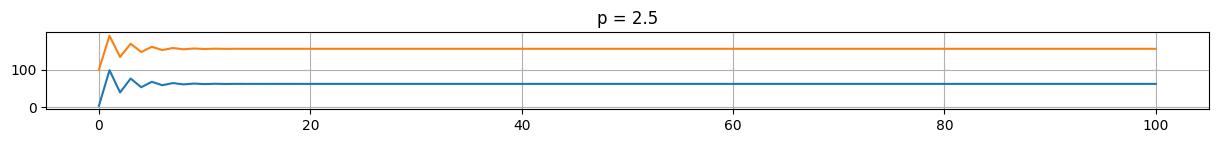

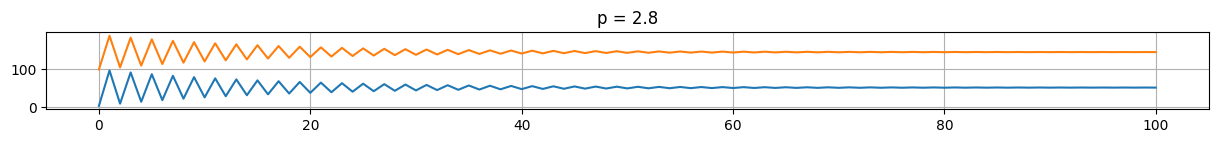

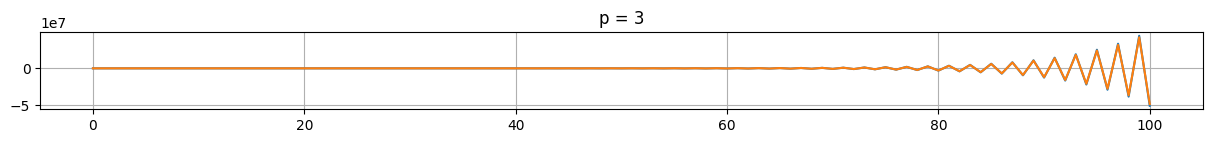

In [8]:
X0 = [4, 100]
for p in [2.5, 2.8, 3]:
    f = vc.VolpiConigli(rv=1.05, rc=2, p=p) # Costruisco la funzione di transizione
    X = sim.simulate(f, X0, n=100)
    sim.plot_sim(X=X, title=f"p = {p}", figsize=(15, 1))